<a href="https://colab.research.google.com/github/cristianrubioa/pale-blue-dot-challenge/blob/main/lab/main_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Main Process**

Methodology for the [NASA's challenge](https://www.drivendata.org/competitions/256/) integrating both quantitative and qualitative analyses using Landsat imagery spanning from 2013 to 2024 over the [Los Glaciares National Park](https://whc.unesco.org/en/list/145/). Landsat Collection-2 Level-2 dataset is selected using Landsat 8 and 9 OLI/TIRS C2 L2 satellites from the [USGS EarthExplorer](https://earthexplorer.usgs.gov/). The Notebook describes the following end-to-end processes:


* Percentage of snow cover using the Normalized Difference Snow Index (NDSI)

* Surface temperature through region-of-interest averaging.

* Generate final visualization

## **Init config**

In [1]:
#@title Installs

!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.1 MB/s eta 0:00:00


In [2]:
#@title Packages

# General purpose
import os
import json
from datetime import datetime
from datetime import timedelta

# Numerical computing
import numpy as np
import seaborn as sns
from scipy.stats import linregress

# Spatial data processing
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.features import geometry_mask

# Visualization
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [3]:
#@title Constants

# Filenames from dowloaded images to test
# 20211225_230095 (clear)
# 20220117_231095 (clear)
# 20230917_231095 (Clear)
# 20231105_230095 (Cloudy)

# Image filename format for band analysis
IMAGE_FILENAME = "20230917_231095_{band}_CROPPED.TIF"

# Dataset directory to original images from USGS EarthExplorer
ORIGINAL_DS = "./dataset/original"

# Dataset directory to clipped images in the region of interest (ROI)
CLIPPED_DS = "./dataset/roi_clipped"

# Directory with all needed data
WORKING_DIRECTORY = "/content/drive/MyDrive/DRIVEN_DATA"

# Path to the selected shapefile with the ROI
SHAPEFILE_PATH = "./Shapefiles/Rectangular_Shape/Rectangle_Shapefile_ROI.shp"

# Path to the JSON dataset to create line plot
JSON_DATA_FILENAME = "/content/drive/MyDrive/DRIVEN_DATA/dataset/landsat_images_tags.json"

# Parameter to generate frame visualization
VISUALIZATION_PARAMS = {
    "Color": {
        "max": 1,
        "min": 0,
        "cmap": "gray",
        "title": "True Color",
        "axis": 0,
    },

    "Temperature": {
        "max": None,
        "min": None,
        "cmap": "RdYlBu_r",
        "title": "Surface Temperature [°C]",
        "axis": 1
    },

    "NDSI": {
        "max": 1,
        "min": -1,
        "cmap": "RdBu",
        "title": "Snow Index (NDSI)",
        "axis": 2
    }
}

# Landsat Level-2 product scale factors and offset
L2SP_FACTORS = {
    # Surface Reflectance (SR)
    "SR": {
        "SCALE_FACTOR": 0.0000275,
        "ADDITIVE_OFFSET": -0.2
    },

    # Surface Temperature (ST)
    "ST": {
        "SCALE_FACTOR": 0.00341802,
        "ADDITIVE_OFFSET": 149
    }
}

# Missing values code for Landsat 8/9 Collection-2 Level-2
# https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide
FILL_VALUE = 0

# Constant to conver from °K to °C
CELCIUS_SCALER = 273.15

In [4]:
#@title File manager

# Link Google Drive Account
from google.colab import drive
drive.mount('/content/drive')

# Change current working directory
os.chdir(WORKING_DIRECTORY)
print("\nWorking directory at:", WORKING_DIRECTORY)

Mounted at /content/drive

Working directory at: /content/drive/MyDrive/DRIVEN_DATA


## **Helper functions**

In [5]:
def read_landsat_band(image_path, normalize=False, fill_value=0):
    """
    Reads a Landsat band from the given file path and returns its raster data
    as a numpy array and metadata as a dictionary. It can optionally normalize
    the band data.

    Args:
        - image_path: str
                      Image path and filename to read

        - normalize: bool
                     Whether to normalize band values or not

        - fill_value: int/float
                      Invalid band value to fill with np.nan

    Return:
        - tuple: returns the raster image and the metadata
    """
    # Read GeoTIF band
    with rasterio.open(image_path) as src:
        # Read raster data
        raster = src.read().astype(np.float32)
        raster[raster == fill_value] = np.nan

        # Read Metadata
        metadata = src.meta

    # Scaled values in range [0, 1]
    if normalize:
        raster -= np.nanmin(raster)
        raster /= (np.nanmax(raster) - np.nanmin(raster))

    return raster.squeeze(), metadata


def show_image(
        image, title="Landsat Imagery", norm=False, cmap="viridis", ax=None
):
    """
    Display an image using matplotlib pyplot

    Args:
        - image: numpy.ndarray
                 Image array to display.

        - title: str, optional
                 Title for the figure. The default is "Landsat Imagery".

        - norm: bool, optional
                Whether to normalize image values. The default is False.

        - cmap: str, optional
                The mapping from image values to color space. If not provided,
                the default will be "viridis".

        - ax: matplotlib Axes, optional
              Axes in which to draw the image, otherwise use the
              currently-active Axes.

    """
    # Remove axes of length one
    image = image.squeeze()

    # Normalize values in range [0, 1] for visualization
    if norm: image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))

    # Max and min plot values
    vmin=np.nanmin(image)
    vmax=np.nanmax(image)

    # Get current axes
    if ax is None: ax = plt.gca()

    # Plot image
    # Other cmaps: viridis, inferno, cividis, RdBu
    plot = ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    if (image.ndim == 2) and (cmap != "gray"): plt.gcf().colorbar(plot)



def replace_suffix_and_extension(
    filename: str, suffix: str | None = None, extension: str | None = None
) -> str:
    """
    Replaces the suffix and extension of a filename.

    Args:
        - filename: The original filename.
        - suffix: The new suffix to replace the existing one. If None, the existing suffix is {UNDEFINED}.
        - extension: The new extension to replace the existing one, without the leading dot.

    Returns:
        - str: The modified filename with the new suffix and/or extension.
    """
    name, ext = os.path.splitext(filename)
    name = name.rsplit("_", 3)[0]
    name += f"_{suffix}" if suffix else "UNDEFINED"
    ext = extension if extension else ext
    return f"{name}.{ext}"

## **Band analysis**



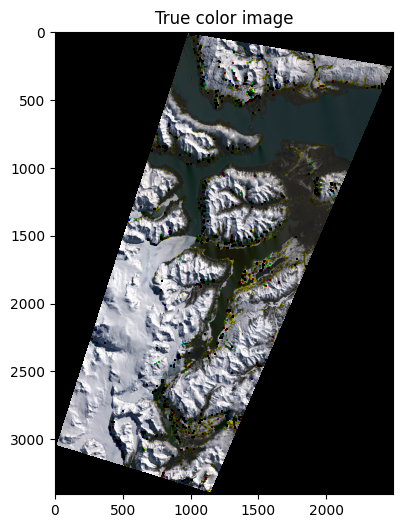

In [ ]:
#@title True color image

def compute_true_color(band_paths, normalize=True, fill_value=0):
    """
    Creates a True Color Image (TCI) from RGB corresponding satelite bands

    Args:
        - band_paths: list(str)
                      Path to band files in RGB sequence

        - normalize: bool
                     Whether to scale values in range [0, 1]
    """
    # RGB images data
    image_true_color = []

    for path in band_paths:
        # Read band data
        image, meta = read_landsat_band(
            image_path=path,
            normalize=normalize,
            fill_value=fill_value
        )

        image_true_color.append(image)

    return np.stack(image_true_color, axis=-1)

# ------------------------------------------------------------------------------



# Get paths for RGB image
band_paths = [
    os.path.join(CLIPPED_DS, IMAGE_FILENAME.format(band=band_name))
    for band_name in ["SR_B4", "SR_B3", "SR_B2"]
]

# Compute True Color Image (TCI)
image_true_color = compute_true_color(
    band_paths=band_paths,
    normalize=True,
    fill_value=FILL_VALUE
)

# Display image
plt.figure(figsize=(6, 6))
show_image(image_true_color, "True color image", norm=True)
plt.show()

Temperature --> Min:-27.36, Max:18.34



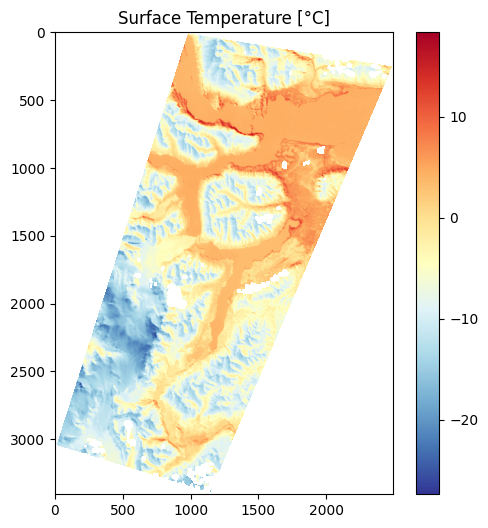

In [ ]:
#@title Surface temperature

def compute_landsat_temperature(
        image_path, band_factors, celcius=True, fill_value=0
    ):
    """
    Compute temperature values from Landsat 8/9 Collection-2 Level-2 data.

    Reads the surface temperature band data from the specified Landsat thermal
    band image and applies the provided scale factors and offset to convert
    the data to temperature values in Kelvin. Optionally, the values can be
    further converted to Celsius.

    Args:
        - image_path: str
                      Path to Landsat thermal band.

        - band_factors: dict
                        Landsat 8/9 Level-2 product scale factors and offset.
                        Must have "SCALE_FACTOR" and "ADDITIVE_OFFSET" keys.

        - celcius: bool, optional
                   Whether to convert temperature values to Celsius.
                   Defaults to True.

        - fill_value: int/float, optional
                      Invalid band value to fill with np.nan.
                      Defaults to 0.

    Returns:
        - ndarray: Array of temperature values in °K or °C, based on the
                   "celcius" argument.
    """

    # Read surface temperature band data
    st_band, meta = read_landsat_band(
        image_path=image_path,
        normalize=False,
        fill_value=fill_value
    )

    # Get scale and offset factors
    scale_factor = band_factors["SCALE_FACTOR"]
    offset = band_factors["ADDITIVE_OFFSET"]

    # Convert uint to floating point values in °K
    temperature = (st_band * scale_factor) + offset

    # Convert values to °C
    if celcius: temperature -= CELCIUS_SCALER

    return temperature

# ------------------------------------------------------------------------------



# Name of thermal band
thermal_band_name = "ST_B10"

# Get path for thermal band
path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band=thermal_band_name)
)

# Compute the temperature in °C
temperature = compute_landsat_temperature(
        image_path=path,
        band_factors=L2SP_FACTORS["ST"],
        celcius=True,
        fill_value=FILL_VALUE
)

# Display temperature range
print(f"Temperature --> "
      f"Min:{np.nanmin(temperature):.2f}, "
      f"Max:{np.nanmax(temperature):.2f}\n")

# Display temperature map
plt.figure(figsize=(6, 6))
show_image(temperature, "Surface Temperature [°C]", cmap="RdYlBu_r")
plt.show()

### Snow Cover

**Normalized Difference Snow Index (NDSI)**

$$NSDI = \frac{GREEN - SWIR1}{GREEN + SWIR1}$$

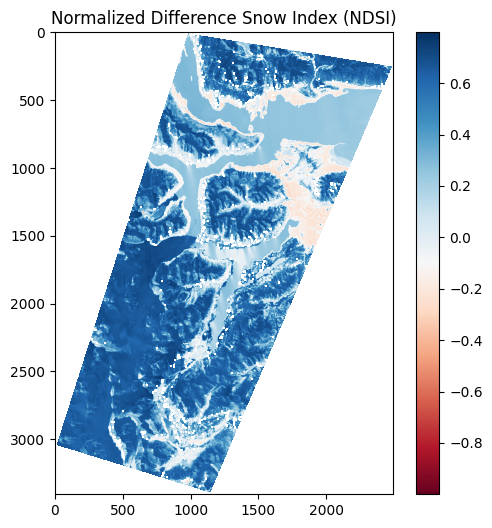

In [27]:
#@title Compute NDSI

def compute_ndsi(green_path, swir_path, fill_value=0):
    """
    Compute Normalized Differenced Snow Index (NDSI) using Landsat green and
    shortwave infrared bands. The result is an array of NDSI values, where
    invalid divisions are ignored.

    Args:
        - green_path: str
                      Path to Landsat green band

        - swir_path: str
                     Path to Landsat shortwave infrared band

        - fill_value: int/float, optional
                      Invalid band value to fill with np.nan. Defaults to 0.

    Returns:
        - ndarray: Array of NDSI values.
    """
    # Read green band data
    green, meta = read_landsat_band(
        image_path=green_path,
        normalize=False,
        fill_value=fill_value
    )

    # Read shortwave infrared band data
    swir, meta = read_landsat_band(
        image_path=swir_path,
        normalize=False,
        fill_value=fill_value
    )

    # Compute NDSI (ignoring invalid divisions)
    np.seterr(divide='ignore', invalid='ignore')
    return  (green - swir) / (green + swir)

# ------------------------------------------------------------------------------



# Get green band path
green_path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B3")
)

# Get shortwave infrared band path
swir_path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B6")
)

# Compute NDSI
ndsi = compute_ndsi(
    green_path=green_path,
    swir_path=swir_path,
    fill_value=FILL_VALUE
)

# Display image
plt.figure(figsize=(6, 6))
show_image(
    image=ndsi,
    title="Normalized Difference Snow Index (NDSI)",
    cmap="RdBu"
)
plt.show()

Total snow pixels: 2417449.0
Snow cover percentage: 53.9%
Snow area [metre]: 2175704100.0



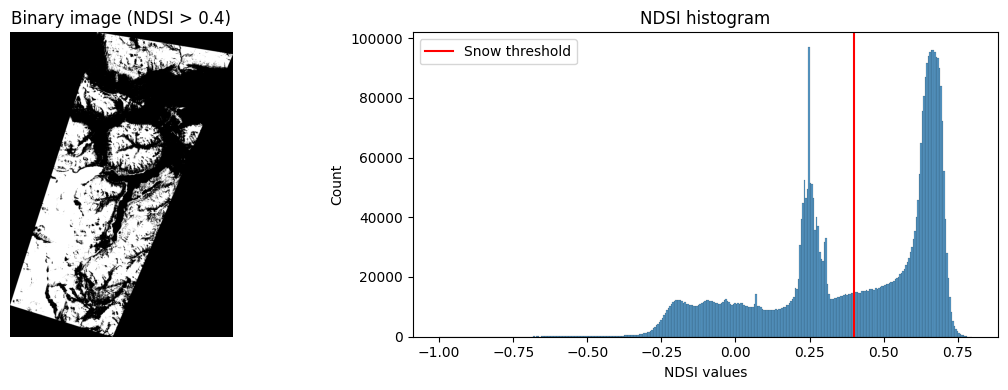

In [33]:
#@title Snow pixels

def get_roi_data(image_path, roi_path):
    """
    Create a Region Of Interest (ROI) binary mask and read the image metadata

    Args:
        - image_path: str
                      Path to Landsat band.

        - roi_path: str
                    Path to ROI shapefile.

    Returns:
        - ndarray: Binary mask representing the Region Of Interest (ROI).

        - dict: Basic metadata information extracted from the input image.

    Notes:
        The function reads a Landsat band image and a Region Of Interest (ROI)
        shapefile, creating a binary mask for the specified ROI. The geometries
        in the shapefile are transformed to match the image coordinate reference
        system (CRS). The function also extracts metadata from the image.
    """
    # Read region-of-interest (ROI) shapefile as GeoDataFrame
    gdf = gpd.read_file(roi_path)

    # Read image data
    with rasterio.open(image_path) as src:
        # Transform geometries to the image coordinate reference system (crs)
        gdf = gdf.to_crs(src.crs)

        # Get the pixel size in meters (images are in UTM CRS)
        metadata = src.meta

        # Get the ROI mask
        roi_mask = geometry_mask(
            geometries=gdf.geometry,
            out_shape=src.read().squeeze().shape,
            transform=src.transform
        )

    return roi_mask, metadata


def get_metrics_data(index_arr, image_path, roi_path, threshold):
    """
    Calculate metrics based on a binary image created from an input index array
    and a region of interest (ROI) shapefile.

    Parameters:
        - index_arr: numpy.ndarray
                     2D array representing the index values of the input image.

        - image_path: str
                      File path to the input Landsat image.

        - roi_path: str
                    File path to the shapefile defining the region of interest.

        - threshold: float
                     Threshold value for binarizing the index image.

    Returns:
        dict: A dictionary containing the following metrics:

            - "binary image": Binary image obtained by applying the threshold
                              to the index array.

            - "num pixels": Number of pixels above the specified threshold in
                            the binary image.

            - "area": Total area covered by pixels above the threshold,
                      calculated using Landsat pixel size.

            - "percentage": Percentage of the region of interest covered by
                            pixels above the threshold.

            - "area units": Linear units of the coordinate reference
                            system (CRS) of the input image.
    """
    # Get bool mask from shapefile
    roi_mask, meta = get_roi_data(image_path, roi_path)

    # Get pixel size
    pixel_size_x = meta["transform"][0]
    pixel_size_y = abs(meta["transform"][4])

    # Get a short name for the linear units of the CRS
    units = meta["crs"].linear_units

    # Binary image
    image_binary = np.zeros_like(ndsi)
    image_binary[ndsi > threshold] = 1

    # Pixel Coverage
    roi_pixels = np.sum(~roi_mask)
    num_pixels = np.sum(image_binary)
    percentage = (num_pixels / roi_pixels) * 100

    # Area Coverage
    roi_area = roi_pixels * pixel_size_x * pixel_size_y
    area = num_pixels * pixel_size_x * pixel_size_y

    return {
        "binary image": image_binary,
        "num pixels": num_pixels,
        "area": area,
        "percentage": percentage,
        "area units": units
    }

# ------------------------------------------------------------------------------



# Threshold for snow classification
threshold = 0.4 #@param {type:"slider", min:-1, max:1, step:0.01}

# Create image path from any band
path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B2")
)

# Get the snow cover data
snow_data = get_metrics_data(
    index_arr=ndsi,
    image_path=path,
    roi_path=SHAPEFILE_PATH,
    threshold=threshold
)

# Binary image
image_binary = snow_data["binary image"]

# Get snow data processed
snow_pixels = snow_data["num pixels"]
snow_percentage = snow_data["percentage"]
snow_area = snow_data["area"]
area_units = snow_data["area units"]

# Display data
print("Total snow pixels:", snow_pixels)
print(f"Snow cover percentage: {snow_percentage:.1f}%")
print(f"Snow area [{area_units}]: {snow_area}")
print()

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Display the binary mask on the left
show_image(
    image=image_binary,
    title=f"Binary image (NDSI > {threshold})",
    cmap="gray",
    ax=axes[0]
)
axes[0].axis('off')

# Display the histogram on the right
sns.histplot(ndsi.flat, ax=axes[1])
axes[1].set_title("NDSI histogram")
axes[1].axvline(x=threshold, color='red', label='Snow threshold')
axes[1].legend()
axes[1].set_xlabel("NDSI values")

# Show the plot
plt.tight_layout()
plt.show()

### SWI

**Snow Water Index**

$$SWI = \frac{GREEN(NIR-SWIR)}{(GREEN + NIR)(NIR + SWIR)}$$

*Reference*

* [Development and Evaluation of a New "Snow Water Index (SWI)" for Accurate Snow Cover Delineation](https://www.mdpi.com/2072-4292/11/23/2774#)

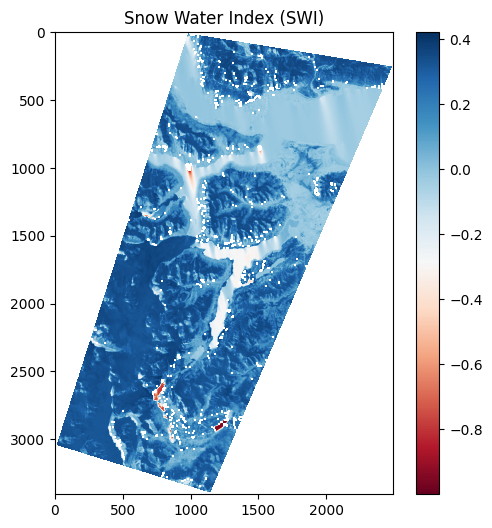

In [35]:
#@title Compute index

def compute_swi(green_path, nir_path, swir_path, fill_value=0):
    """
    Compute the Snow Water Index (SWI) using Landsat green, near-infrared,
    and shortwave infrared bands. The result is an array of SWI values, with
    invalid divisions ignored.

    Args:
        - green_path: str
                      Path to Landsat green band

        - nir_path: str
                    Path to Landsat near infrared band

        - swir_path: str
                     Path to Landsat shortwave infrared band

        - fill_value: int/float, optional
                      Invalid band value to fill with np.nan.
                      Defaults to 0.

    Returns:
        ndarray: Array of Snow Water Index (SWI) values.
    """
    # Read green band data
    green, meta = read_landsat_band(
        image_path=green_path,
        normalize=False,
        fill_value=fill_value
    )

    # Read shortwave infrared band data
    swir, meta = read_landsat_band(
        image_path=swir_path,
        normalize=False,
        fill_value=fill_value
    )

    # Read neat infrared band data
    nir, meta = read_landsat_band(
        image_path=nir_path,
        normalize=False,
        fill_value=fill_value
    )

    # Compute NDSI (ignoring invalid divisions)
    np.seterr(divide='ignore', invalid='ignore')
    return (green * (nir - swir)) / ( (green + nir) * (nir + swir) )

# ------------------------------------------------------------------------------



# Get green band path
green_path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B3")
)

# Get shortwave infrared band path
swir_path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B6")
)

# Get near infrared band path
nir_path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B5")
)

# Compute SWI
swi = compute_swi(
    green_path=green_path,
    nir_path=nir_path,
    swir_path=swir_path,
    fill_value=FILL_VALUE
)

# Display image
plt.figure(figsize=(6, 6))
show_image(
    image=swi,
    title="Snow Water Index (SWI)",
    cmap="RdBu"
)
plt.show()

Total snow pixels: 3488218.0
Snow cover percentage: 77.7%
Snow area [metre]: 3139396200.0



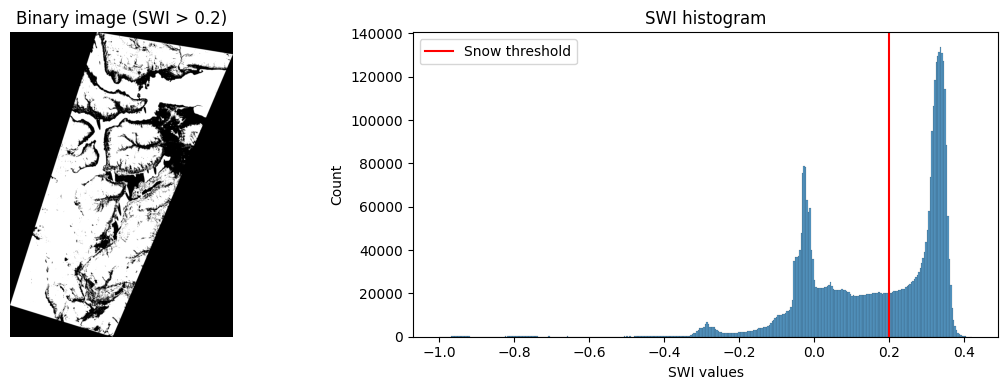

In [36]:
#@title Snow pixels

# Threshold for snow classification
threshold = 0.2 #@param {type:"slider", min:-1, max:1, step:0.01}

# Create image path from any band
path = os.path.join(
    CLIPPED_DS,
    IMAGE_FILENAME.format(band="SR_B2")
)

# Get the snow cover data
snow_data = get_metrics_data(
    index_arr=swi,
    image_path=path,
    roi_path=SHAPEFILE_PATH,
    threshold=threshold
)

# Binary image
image_binary = snow_data["binary image"]

# Get snow data processed
snow_pixels = snow_data["num pixels"]
snow_percentage = snow_data["percentage"]
snow_area = snow_data["area"]
area_units = snow_data["area units"]

# Display data
print("Total snow pixels:", snow_pixels)
print(f"Snow cover percentage: {snow_percentage:.1f}%")
print(f"Snow area [{area_units}]: {snow_area}")
print()


# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Display the binary mask on the left
show_image(
    image=image_binary,
    title=f"Binary image (SWI > {threshold})",
    cmap="gray",
    ax=axes[0]
)
axes[0].axis('off')

# Display the histogram on the right
sns.histplot(swi.flat, ax=axes[1])
axes[1].set_title("SWI histogram")
axes[1].axvline(x=threshold, color='red', label='Snow threshold')
axes[1].legend()
axes[1].set_xlabel("SWI values")

# Show the plot
plt.tight_layout()
plt.show()

## **Generate visualization**

### Methods

In [ ]:
#@title data_for_line_plot

def data_for_line_plot(json_data_filename, vis_params):
    """
    Extract and organize data from a JSON file for visualization in a line plot.

    Args:
        - json_data_filename: str
                              File path to the JSON dataset file.

        - vis_params: dict
                      Dictionary containing visualization parameters.

    Return:
        dict: Updated "vis_params" dictionary containing extracted data
              from JSON dataset.
    """
    # Data for line plot
    json_keys = []
    dates = []
    temperatures = []
    snow_cover_percentages = []
    cloud_presence = []

    # Read JSON data from file
    with open(json_data_filename) as file:
        json_data = json.load(file)

    # Read JSON dataset values
    for key, values in json_data.items():
        # Get date from JSON key
        date_str = key.split("_")[0]

        # Add data to memory
        json_keys.append(key)
        dates.append(datetime.strptime(date_str, "%Y%m%d"))
        temperatures.append(values["temperature_roi"])
        snow_cover_percentages.append(values["snow_cover_per"])
        cloud_presence.append(values["has_clouds"])

    my_dict = {
        "date": {
            "all": dates,
            "min": dates[0] - timedelta(days=90),
            "max": dates[-1] + timedelta(days=90),
        },

        "temperature": {
            "all": temperatures,
            "min": np.floor(min(temperatures) - 3),
            "max": np.ceil(max(temperatures) + 3),
        },

        "snow": {
            "all": snow_cover_percentages,
            "min": np.floor(min(snow_cover_percentages) - 3),
            "max": np.ceil(max(snow_cover_percentages) + 3),
        },

        "cloud": {
            "all": cloud_presence,
        },

        "key": {
            "all": json_keys,
        },
    }

    # Add read data to visualization params
    vis_params["JSON_data"] = my_dict

    return vis_params

In [ ]:
#@title get_images_to_show

def get_images_to_show(image_filename):
    """
    Generate and return various processed images for visualization.

    Parameters:
        - image_filename: str
                          Base filename format for Landsat image bands.

    Returns:
        dict: A dictionary containing different processed images:

            - "Color": True Color Image (TCI) computed from Red, Green,
                       and Blue bands.

            - "Temperature": Temperature image computed from the thermal band.

            - "NDSI": Normalized Difference Snow Index (NDSI) computed from
                      Green and Shortwave Infrared bands.
    """
    # True Color Image (TCI)
    #---------------------------------------------------------------------------
    # Get paths for RGB image
    true_color_paths = [
        os.path.join(CLIPPED_DS, image_filename.format(band=band_name))
        for band_name in ["SR_B4", "SR_B3", "SR_B2"]
    ]

    # Compute TCI
    image_true_color = compute_true_color(
        band_paths=true_color_paths,
        normalize=True,
        fill_value=FILL_VALUE
    )

    # NaN mask for RGB bands
    nan_mask = np.logical_or(
        ~np.isfinite(image_true_color[:, :, 0]),
        ~np.isfinite(image_true_color[:, :, 1]),
        ~np.isfinite(image_true_color[:, :, 2])
    )

    # Fill RGB bands based on mask
    image_true_color[nan_mask, 0] = np.nan
    image_true_color[nan_mask, 1] = np.nan
    image_true_color[nan_mask, 2] = np.nan
    #---------------------------------------------------------------------------


    # Temperature image
    #---------------------------------------------------------------------------
    # Get path for thermal band
    thermal_path = os.path.join(
        CLIPPED_DS,
        image_filename.format(band="ST_B10")
    )

    # Compute the temperature in °C
    image_temperature = compute_landsat_temperature(
            image_path=thermal_path,
            band_factors=L2SP_FACTORS["ST"],
            celcius=True,
            fill_value=FILL_VALUE
    )
     #---------------------------------------------------------------------------


    # NDSI image
    #---------------------------------------------------------------------------
    # Get green band path
    green_path = os.path.join(
        CLIPPED_DS,
        image_filename.format(band="SR_B3")
    )

    # Get shortwave infrared band path
    swir_path = os.path.join(
        CLIPPED_DS,
        image_filename.format(band="SR_B6")
    )

    # Compute NDSI
    image_ndsi = compute_ndsi(
        green_path=green_path,
        swir_path=swir_path,
        fill_value=FILL_VALUE
    )
    #---------------------------------------------------------------------------


    return {
        "Color": image_true_color,
        "Temperature": image_temperature,
        "NDSI": image_ndsi,
    }

In [ ]:
#@title display_images

def display_images(images, vis_params, axes, figure):
    """
    Display multiple images on specified axes with given visualization
    parameters.

    Args:
        - images: dict
                  A dictionary containing image names as keys and corresponding
                  image data as values. Must be three.

        - vis_params: dict
                      Visualization parameters for each image, including:
                      axis number, min, max, cmap, and title. The primary keys
                      must match with "images" argument keys.

        - axes: list
                List of matplotlib axes where images will be displayed.

        - figure: matplotlib.pyplot.figure
                  Current matplotlib figure object where the images are
                  displayed

    Raises:
        - ValueError: If the number of images does not match the number of axes.

    Returns:
        None
    """
    # Check input args
    if len(images) != len(axes):
        error_message = "Number of images must be the same of axes."
        raise ValueError(error_message)

    # Display images
    for image_name, image in images.items():
        # Get visualization parameters
        axis_num = vis_params[image_name]["axis"]
        vmin = vis_params[image_name]["min"]
        vmax = vis_params[image_name]["max"]
        cmap = vis_params[image_name]["cmap"]
        title = vis_params[image_name]["title"]

        if (vmin is None) or (vmax is None):
            vmin = np.nanmin(image)
            vmax = np.nanmax(image)

        # Get axis
        ax = axes[axis_num]

        # Display image
        image_plot = ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.axis("off")

        # Include title and color bar
        ax.set_title(title)
        if (image.ndim == 2) and (cmap != "gray"):
            figure.colorbar(image_plot, ax=ax, orientation="vertical")

In [ ]:
#@title display_line_plot_by_index

def display_line_plot_by_index(index, json_data, ax=None):
    """
    Display a line plot with temperature, snow cover percentage, and cloud
    presence up to a specified index.

    Args:
        - index: int
                 Index up to which data will be displayed on the line plot.

        - json_data: dict
                     Dictionary containing historical temperature,
                     snow cover, date, and cloud presence data.

                    Each primary value is a dictionary with a mandatory
                    key: "all" and two optional keys: "min", "max"

        - ax: matplotlib.axes.Axes, optional
              Matplotlib axes for plotting. If None, a new subplot is created.

    Returns:
        None
    """
    # Get axis to plot
    if ax is None: fig, ax1 = plt.subplots()
    else: ax1 = ax

    # Get plot data from JSON
    temperature_data = json_data["temperature"]
    date_data = json_data["date"]
    snow_data = json_data["snow"]
    cloud_data = json_data["cloud"]



    # Create temperature line plot (left y-axis)
    (temp_line, ) = ax1.plot(
        date_data["all"][0 : index + 1],
        temperature_data["all"][0 : index + 1],
        color="tab:red",
        label="Temperature",
        marker="o",
    )

    # Config temperature line plot
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Mean temperature [°C]", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")
    ax1.set_ylim(
        bottom=temperature_data["min"],
        top=temperature_data["max"],
    )
    ax1.set_xlim(
        left=date_data["min"],
        right=date_data["max"],
    )

    # Add trendline for temperature
    slope_temp, intercept_temp, _, _, _ = linregress(
        range(len(date_data["all"][0 : index + 1])),
        temperature_data["all"][0 : index + 1],
    )
    trendline_temp = [
        slope_temp * i + intercept_temp
        for i in range(len(date_data["all"][0 : index + 1]))
    ]
    (trendline1, ) = ax1.plot(
        date_data["all"][0 : index + 1],
        trendline_temp,
        linestyle="dashed",
        color="tab:red",
        label="Temperature Trendline",
    )



    # Snow cover percentage plot (right y-axis)
    ax2 = ax1.twinx()
    (snow_line,) = ax2.plot(
        date_data["all"][0 : index + 1],
        snow_data["all"][0 : index + 1],
        color="tab:blue",
        label="Snow Cover",
        marker="o",
    )

    # Config snow cover line plot
    ax2.set_ylabel("Snow Cover [%]", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylim(
        bottom=snow_data["min"],
        top=snow_data["max"],
    )

    # Add trendline for snow cover percentage
    slope_snow, intercept_snow, _, _, _ = linregress(
        range(len(date_data["all"][0 : index + 1])),
        snow_data["all"][0 : index + 1],
    )
    trendline_snow = [
        slope_snow * i + intercept_snow
        for i in range(len(date_data["all"][0 : index + 1]))
    ]
    (trendline2, ) = ax2.plot(
        date_data["all"][0 : index + 1],
        trendline_snow,
        linestyle="dashed",
        color="tab:blue",
        label="Snow Cover Trendline",
    )



    # Vertical dotted line for cloud presence
    for i, cloud in enumerate(cloud_data["all"][0 : index + 1]):
        if cloud:
            ax1.axvline(
                x=date_data["all"][0 : index + 1][i],
                linestyle="dotted",
                color="gray",
            )

    # Custom legend entry for cloud presence
    legend_elements = [
        Line2D(
            xdata=[0],
            ydata=[0],
            linestyle="dotted",
            color="gray",
            label="Cloud Presence",
        )
    ]

    # Combine legend handles for line plots and cloud presence
    legend_handles = [
        temp_line,
        snow_line,
        trendline1,
        trendline2,
        *legend_elements
    ]

    # Hide the legend for ax2
    ax2.legend().set_visible(False)

    # Legend below the line plot
    ax1.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=4
    )

In [ ]:
#@title display_historic_line_plot

def display_historic_line_plot(json_data, ax=None):
    """
    Display a historic line plot with temperature, snow cover percentage,
    and cloud presence.

    Args:
        - json_data: dict
                     Dictionary containing temperature, snow cover, date, and
                     cloud presence data.

                    Each primary value is a dictionary with a mandatory
                    key: "all" and two optional keys: "min", "max"

        - ax: matplotlib.axes.Axes, optional
              Matplotlib axes for plotting. If None, a new subplot is created.

    Returns:
        None
    """
    # Get axis to plot
    if ax is None: fig, ax1 = plt.subplots()
    else: ax1 = ax

    # Get plot data from JSON
    temperature_values = json_data["temperature"]["all"]
    date_values = json_data["date"]["all"]
    snow_values = json_data["snow"]["all"]
    cloud_values = json_data["cloud"]["all"]



    # Create temperature line plot (left y-axis)
    (temp_line, ) = ax1.plot(
        date_values,
        temperature_values,
        color="tab:red",
        label="Temperature",
        marker="o",
    )

    # Config temperature line plot
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Mean temperature [°C]", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # Add trendline for temperature
    slope_temp, intercept_temp, _, _, _ = linregress(
        range(len(date_values)),
        temperature_values,
    )
    trendline_temp = [
        slope_temp * i + intercept_temp
        for i in range(len(date_values))
    ]
    (trendline1, ) = ax1.plot(
        date_values,
        trendline_temp,
        linestyle="dashed",
        color="tab:red",
        label="Temperature Trendline",
    )



    # Snow cover percentage plot (right y-axis)
    ax2 = ax1.twinx()
    (snow_line,) = ax2.plot(
        date_values,
        snow_values,
        color="tab:blue",
        label="Snow Cover",
        marker="o",
    )

    # Config snow cover line plot
    ax2.set_ylabel("Snow Cover [%]", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # Add trendline for snow cover percentage
    slope_snow, intercept_snow, _, _, _ = linregress(
        range(len(date_values)),
        snow_values,
    )
    trendline_snow = [
        slope_snow * i + intercept_snow
        for i in range(len(date_values))
    ]
    (trendline2, ) = ax2.plot(
        date_values,
        trendline_snow,
        linestyle="dashed",
        color="tab:blue",
        label="Snow Cover Trendline",
    )



    # Vertical dotted line for cloud presence
    for i, cloud in enumerate(cloud_values):
        if cloud:
            ax1.axvline(
                x=date_values[i],
                linestyle="dotted",
                color="gray",
            )

    # Custom legend entry for cloud presence
    legend_elements = [
        Line2D(
            xdata=[0],
            ydata=[0],
            linestyle="dotted",
            color="gray",
            label="Cloud Presence",
        )
    ]

    # Combine legend handles for line plots and cloud presence
    legend_handles = [
        temp_line,
        snow_line,
        trendline1,
        trendline2,
        *legend_elements
    ]

    # Hide the legend for ax2
    ax2.legend().set_visible(False)

    # Legend below the line plot
    ax1.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=4
    )

### Frame Processor

In [ ]:
#@title Parameters

# Get visualization parameter and data
visualization_params = data_for_line_plot(
    json_data_filename=JSON_DATA_FILENAME,
    vis_params=VISUALIZATION_PARAMS
)

# Directory to save output frames
output_directory = "./dataset/frame_visualization"

# Get some JSON data
json_data = visualization_params["JSON_data"]
key_list = json_data["key"]["all"]
date_values = json_data["date"]["all"]
total_samples = len(key_list)

Process start...
Displaying...



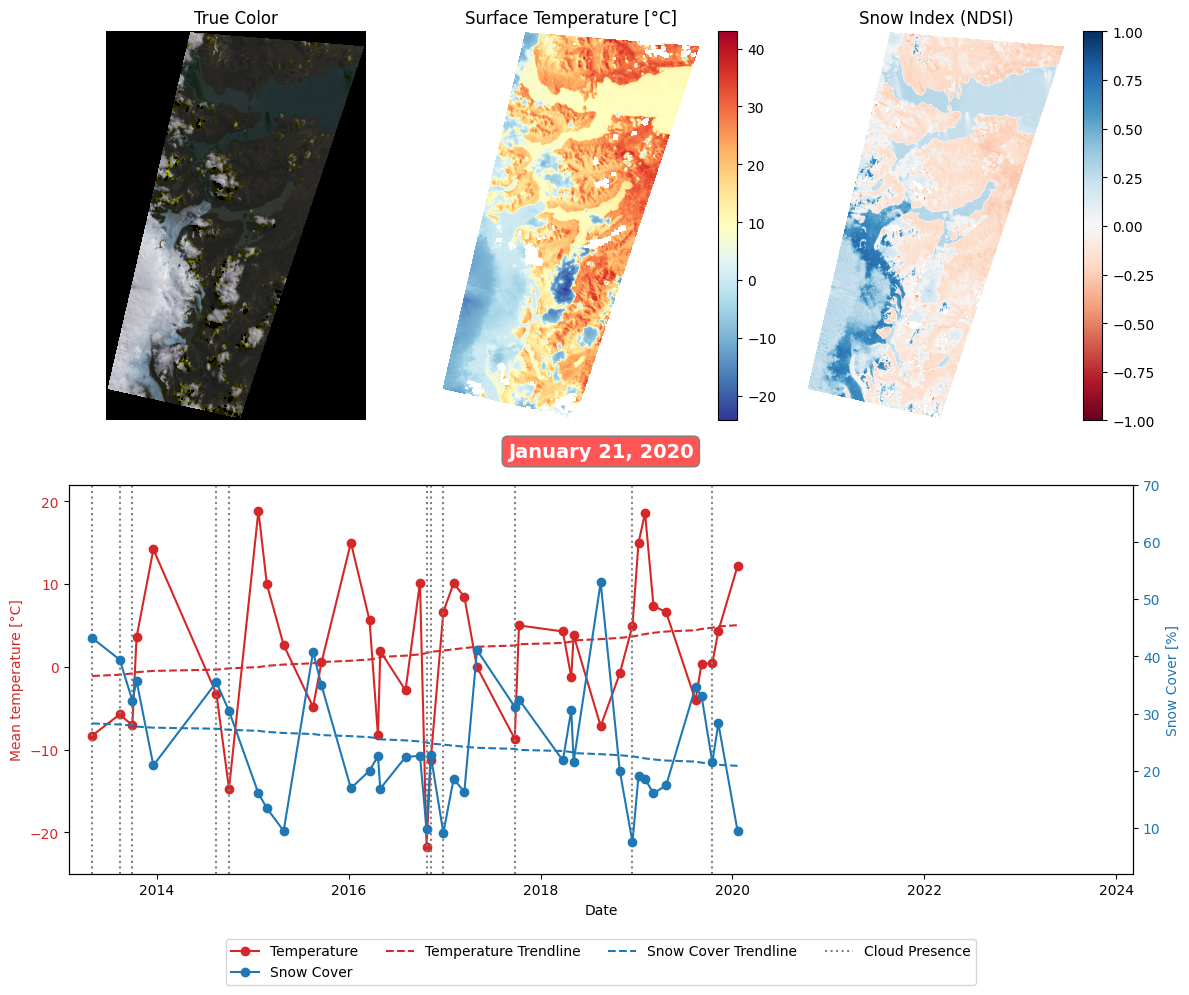

In [ ]:
#@title Visualize by index

index = 40 # @param {type:"integer"}
assert index < 74, "Index out of range. Valid range [0, 73]"
print("Process start...")


# Encapsulate all of the following code inside a loop to
# generate all the frames for a video
# for index in range(total_samples):

# Create figure object
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 3, figure=fig)

# Create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0]) # Upper left
ax2 = fig.add_subplot(gs[0, 1]) # Upper center
ax3 = fig.add_subplot(gs[0, 2]) # Upper rigth
ax4 = fig.add_subplot(gs[1, :]) # lower

# Get current image filename and images to display
image_filename = key_list[index] + "_{band}_CROPPED.TIF"
images_dict = get_images_to_show(image_filename)

# Display images at row 0
display_images(
    images=images_dict,
    vis_params=visualization_params,
    axes=[ax1, ax2, ax3],
    figure=fig
)

# Display line plot
display_line_plot_by_index(
    index=index,
    json_data=json_data,
    ax=ax4
)

# Add figure text
suptitle_date = date_values[index].strftime("%B %d, %Y")
ax4.set_title(
    suptitle_date,
    fontsize=14,
    fontweight="bold",
    color="white",
    # x=0.05,
    y=1.05,
    bbox={
        "facecolor": "#ff5555",
        "edgecolor": "gray",
        "boxstyle": "round,pad=0.3",
    },
)
plt.tight_layout()

# Get ouput filename
new_filename = replace_suffix_and_extension(
    filename=image_filename, suffix="VIDEO_FRAME", extension="png"
)
output_image_path = os.path.join(output_directory, new_filename)

# Save current frame (commented for test)
# plt.savefig(output_image_path, bbox_inches="tight", pad_inches=0, dpi=300)
# plt.close()




# If usign FOR LOOP, skip/comment this part
print("Displaying...\n")
plt.show()

Displaying...



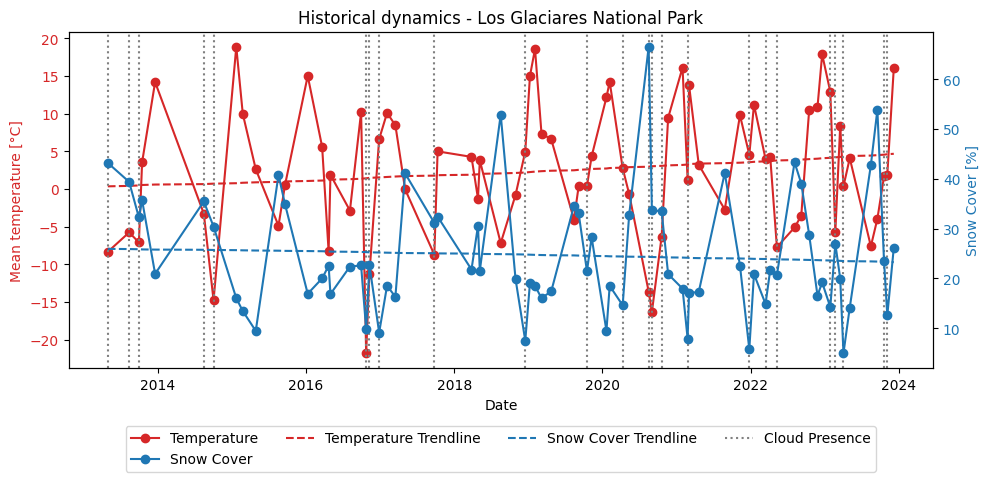

In [ ]:
#@title Visualize historical

# Display line plot
fig, ax = plt.subplots(figsize=(10, 5))
display_historic_line_plot(json_data=json_data, ax=ax)
plt.title("Historical dynamics - Los Glaciares National Park")
plt.tight_layout()

# Get ouput filename
new_filename = replace_suffix_and_extension(
    filename=image_filename, suffix="HISTORIC_IMAGE", extension="png"
)
output_image_path = os.path.join(output_directory, new_filename)

# Save current frame
# plt.savefig(output_image_path, bbox_inches="tight", pad_inches=0, dpi=300)
# plt.close()





print("Displaying...\n")
plt.show()

## **Complementray data**

### Affine Matrix

**Rasterio:** `affine.Affine(a, b, c, d, e, f)`

**GDAL:** `affine.Affine(c, a, b, f, d, e)`

- **a**: w-e pixel resolution / pixel width

- **b**: row rotation (typically zero)

- **c**: x-coordinate of the upper-left corner of the upper-left pixel

- **d**: column rotation (typically zero)

- **e**: n-s pixel resolution / pixel height (negative value for a north-up image)

- **f**: y-coordinate of the upper-left corner of the upper-left pixel

**References:**

- [affine.Affine() vs. GDAL-style geotransforms](https://rasterio.readthedocs.io/en/stable/topics/migrating-to-v1.html#affine-affine-vs-gdal-style-geotransforms)

- [Coordinate Transformation | Affine](https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html#affine)

- [GeoTransforms | GDAL](https://gdal.org/tutorials/geotransforms_tut.html)